# Machine Failure Classification

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.decomposition import PCA

# K Best columns
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif


from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2, l1
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Functions

In [49]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()
  
    
def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores


def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', model)])
        scores = evaluate_model(X, y, pipeline)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def get_over_sampling_methods(X, y, name):
  
  sampling_models = {
    "KNN-SMOTE":SMOTE(k_neighbors=5, random_state=42),
    "BL-SMOTE": BorderlineSMOTE(kind='borderline-1', random_state=42),
    "SMOTE": SMOTE(),
    "ADASYN": ADASYN(random_state=42)
  }
  
  smapling_model = sampling_models[name]
  X_res, y_res = smapling_model.fit_resample(X, y)
  
  return (X_res, y_res)

def svm_tune_grid_search(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('power_transformer', PowerTransformer()),
        ('model', SVC())
    ])
    
    param_grid = {
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_test_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    cr = classification_report(y_test, y_test_pred)
    print(cr)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for SVC')
    plt.show()
    
    return grid_search

def logistic_regression_tune_cv(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('power_transformer', PowerTransformer()),
        ('model', LogisticRegression(class_weight='balanced', penalty='l2', max_iter=2000))
    ])
    param_grid = {
        'model__solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
        'model__C': [0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10, 20, 50, 100, 400]
    }
    metric = make_scorer(f1_score)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=metric, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_test_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    cr = classification_report(y_test, y_test_pred)
    print(cr)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for SVC')
    plt.show()
def val_grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('power_transformer', PowerTransformer()),
        ('model', model)
    ])
        grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        y_pred = best_model.predict(X_val)
        y_test_pred = best_model.predict(X_test)
        
        val_accuracy = accuracy_score(y_val, y_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)    
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Validation Test accuracy for {name}: {val_accuracy:.3f}')
        print(f'Test accuracy for {name}: {test_accuracy:.3f}')
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_test_pred)
        cr = classification_report(y_test, y_test_pred)
        print(cr)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Validation Accuracy": val_accuracy,
                "Test Accuracy": test_accuracy,
                "Best Parameters": grid_search.best_params_
        })
    return pd.DataFrame(model_performance).sort_values(by="Test Accuracy", ascending=False)
def pca_analysis(X):
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  
  features = X.shape[1]
  results = []
  for n_components in range(1, features + 1):
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
        
        explained_variance = np.sum(pca.explained_variance_ratio_)
        
        results.append({
            'Number of Components': n_components,
            'Cumulative Explained Variance': explained_variance
        })
  results_df = pd.DataFrame(results)
  return results_df

def test_k_best_columns(names, models, X, y, metric, metric_name, variance_window):
    
    model_performance = []
    total_score, runs = 0, 0
    for k in variance_window:
        fs = SelectKBest(score_func=metric, k=k)
        for i in range(len(models)):
            model = models[i]
            pipeline = Pipeline(steps=
                                [('scaler', StandardScaler()), 
                                ("power_tranformer",PowerTransformer()), 
                                (metric_name, fs),
                                ('model', model)])
            scores = evaluate_model(X, y, pipeline)
            mean_score = np.mean(scores)
            total_score += mean_score
            runs+=1
            model_performance.append({
                "Model": names[i],
                "Col #": k,
                "Metric": metric_name,
                "Mean": mean_score,
                "STD":np.std(scores)
            })
    performance_df = pd.DataFrame(model_performance)
    print(f"Average total Score: {total_score/runs}")
    return performance_df.sort_values(by="Mean", ascending=False)

def test_train_test_val_splits_on_models(names, models, X, y, kbest, kbest_name, metric):
    model_performance = []
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
    
    for i in range(len(models)):
        model, model_name = models[i], names[i]
        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()), 
            ("power_tranformer",PowerTransformer()), 
            (kbest_name, SelectKBest(score_func=metric, k=kbest)),
            ('model', model)])
        pipeline.fit(X_train, y_train)
        
        y_val_pred = pipeline.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        y_test_pred = pipeline.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        model_performance.append({
            "Model": model_name,
            "Validation Accuracy": val_accuracy,
            "Test Accuracy": test_accuracy
        })
        cr = classification_report(y_test, y_test_pred)
        print(cr)
        conf_mat = confusion_matrix(y_test,y_test_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix {model_name}')
        plt.show()
        
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Test Accuracy", ascending=False)

# EDA Analysis

In [5]:
df = pd.read_csv("/Users/maukanmir/Downloads/machine_failure_cleaned.csv")
df

,Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Machine failure
0,1551,42.8,0,0,0,0,0,0
1,1408,46.3,3,0,0,0,0,0
2,1498,49.4,5,0,0,0,0,0
3,1433,39.5,7,0,0,0,0,0
4,1408,40.0,9,0,0,0,0,0
...,...,...,...,...,...,...,...,...
9810,1604,29.5,14,0,0,0,0,0
9811,1632,31.8,17,0,0,0,0,0
9812,1645,33.4,22,0,0,0,0,0
9813,1408,48.5,25,0,0,0,0,0


# Check For Nulls and Dupes

In [6]:
print(f"Null Count: {df.isna().sum()}")
print(f"Dupe Count: {df.duplicated().sum()}")

Null Count: Rotational speed [rpm]    0
Torque [Nm]               0
Tool wear [min]           0
TWF                       0
HDF                       0
PWF                       0
OSF                       0
Machine failure           0
dtype: int64
Dupe Count: 6


In [7]:
df.drop_duplicates(inplace=True)

# Check Class Imbalance

Class=0, Count=9523, Percentage=97.084%
Class=1, Count=286, Percentage=2.916%


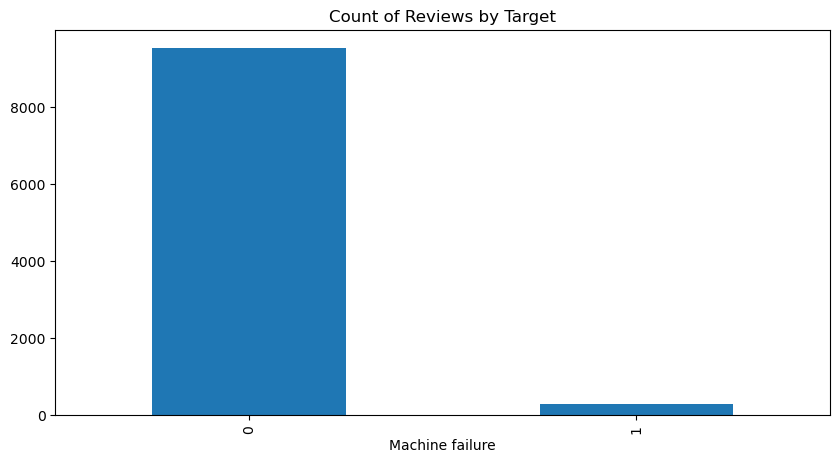

In [8]:
check_class_imbalance(df,df['Machine failure'], 'Machine failure')

# Extreme Class Imbalance which will have to be addressed through sampling methods

In [9]:
df.dtypes

Rotational speed [rpm]      int64
Torque [Nm]               float64
Tool wear [min]             int64
TWF                         int64
HDF                         int64
PWF                         int64
OSF                         int64
Machine failure             int64
dtype: object

In [10]:
df.describe()

,Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,Machine failure
count,9809.000000,9809.000000,9809.000000,9809.000000,9809.000000,9809.000000,9809.000000,9809.000000
mean,1526.408095,40.329728,107.926802,0.004486,0.011724,0.004486,0.009583,0.029157
std,147.339453,9.422408,63.605989,0.066828,0.107646,0.066828,0.097428,0.168255
min,1168.000000,16.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1422.000000,33.600000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1501.000000,40.200000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1606.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2076.000000,68.900000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Visuals

<AxesSubplot:>

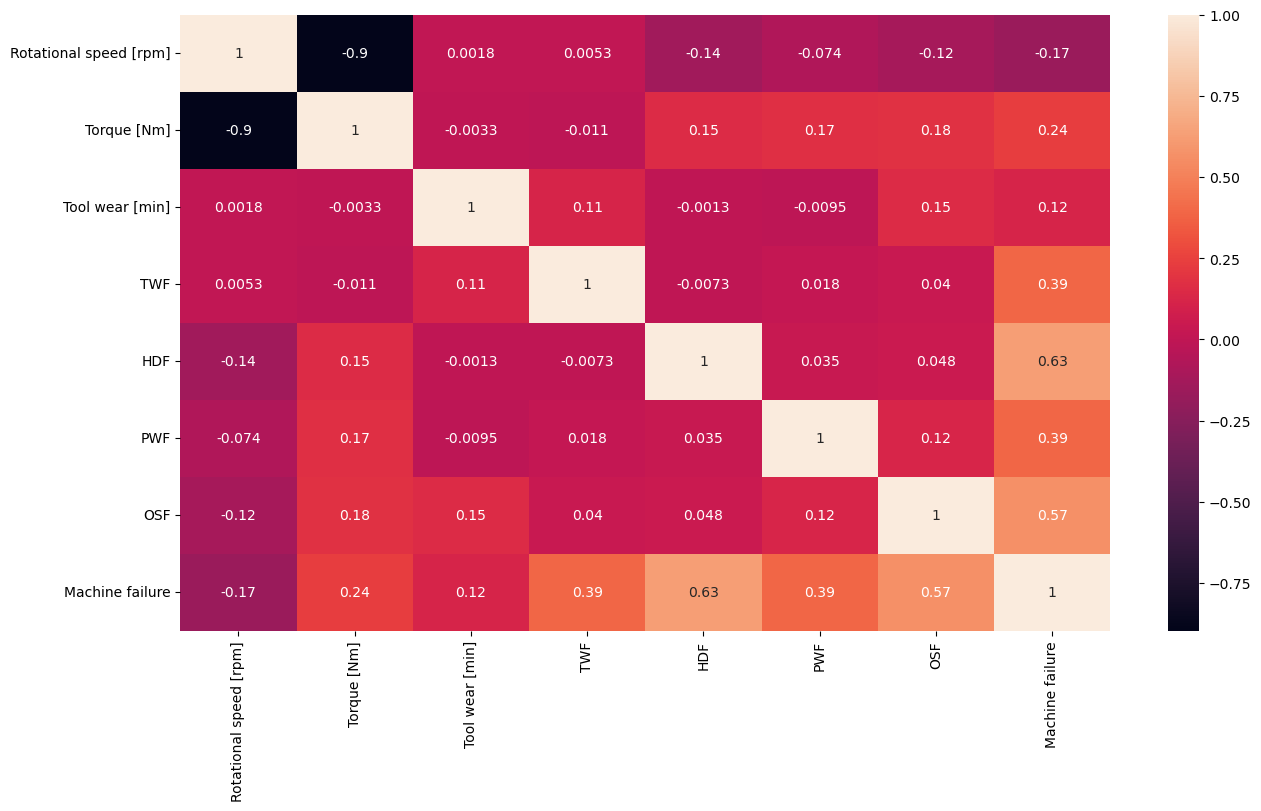

In [11]:
plt.figure(figsize=(15,8))
sns.heatmap(data=df.corr(), annot=True)

# Lot of high correlations with a dataset that has only 8 columns is a great sign

<AxesSubplot:xlabel='Machine failure', ylabel='HDF'>

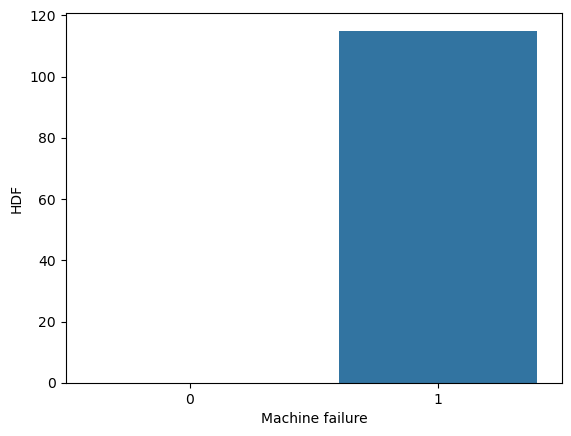

In [14]:

grouped_by_HDF = df.groupby("Machine failure")["HDF"].sum().reset_index()

sns.barplot(data=grouped_by_HDF, x="Machine failure", y="HDF")

# Separate Features

In [15]:

X,y = df.drop("Machine failure", axis=1), df['Machine failure']

# Baseline Model Metrics

In [16]:
model = DummyClassifier(strategy="constant", constant=1)
scores = evaluate_model(X,y, model)
print('Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean: 0.057 (0.000)


# Advanced Model Metrics

In [17]:
names = ['LDA', 'LR', 'SVC', 'GNB', "GPC"]
models = get_selected_models(names)
testing_selected_models(names, models, X, y)

,Model,Mean,STD
0,LDA,0.98389,0.010017
1,LR,0.98389,0.010017
2,SVC,0.98389,0.010017
3,GNB,0.98389,0.010017
4,GPC,0.98389,0.010017


In [18]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X, y)

,Model,Mean,STD
0,RFC,0.983890,0.010017
2,XGB,0.983310,0.010848
3,GBC,0.979333,0.011877
1,DTC,0.960274,0.019523


# The model is overfitting, due to severe class imbalance

# SMOTE Over sampling methods

In [19]:
X_smote, y_smote = get_over_sampling_methods(X, y, "SMOTE")

In [21]:
names = ['LR', 'SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
1,SVC,0.935379,0.004127
0,LR,0.915210,0.004392


In [22]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
0,RFC,0.967586,0.002149
2,XGB,0.964774,0.001871
1,DTC,0.958856,0.003219
3,GBC,0.944060,0.004364


# ADASYN

In [23]:

X_adasyn, y_adasyn = get_over_sampling_methods(X, y, "ADASYN")

In [24]:
names = ['LR', 'SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X_adasyn, y_adasyn)

,Model,Mean,STD
1,SVC,0.926563,0.004626
0,LR,0.907296,0.004890


In [25]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X_adasyn, y_adasyn)

,Model,Mean,STD
0,RFC,0.965513,0.002884
2,XGB,0.963583,0.002205
1,DTC,0.955524,0.003670
3,GBC,0.939297,0.003889


# Borderline SMOTE

In [26]:
X_bl, y_bl = get_over_sampling_methods(X, y, "BL-SMOTE")

In [28]:
names = ['LR', 'SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X_bl, y_bl)

,Model,Mean,STD
1,SVC,0.960512,0.003562
0,LR,0.938013,0.003500


In [29]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X_bl, y_bl)

,Model,Mean,STD
0,RFC,0.982089,0.002147
2,XGB,0.981669,0.001683
1,DTC,0.975776,0.002394
3,GBC,0.967618,0.003370


# KNN-SMOTE

In [30]:
X_knn, y_knn = get_over_sampling_methods(X, y, "KNN-SMOTE")

In [31]:
names = ['LR', 'SVC']
models = get_selected_models(names)
testing_selected_models(names, models, X_knn, y_knn)

,Model,Mean,STD
1,SVC,0.935843,0.003080
0,LR,0.915550,0.003979


In [32]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X_knn, y_knn)

,Model,Mean,STD
0,RFC,0.966402,0.002104
2,XGB,0.964750,0.002334
1,DTC,0.957521,0.004644
3,GBC,0.941583,0.003011


# Borderline SMOTE has the best performance

# MLP Tuning

In [34]:
def create_keras_classifier(function, optimizer, idx, param, validation_data):
    if idx == 0 or idx ==3:
        
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer)
            , epochs=100, 
            batch_size=64, 
            verbose=0,
            validation_data= validation_data
            )
    elif idx ==1:
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer, param=param)
            , epochs=100, 
            batch_size=64, 
            verbose=0,
            validation_data= validation_data
            )
        
    else:
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer, param=param)
            , epochs=100, 
            batch_size=64, 
            verbose=0,
            validation_data= validation_data
            )
    return model

def create_model_dropout(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_regularizerl2(input_dim, optimizer="adam",param= 0.001):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(param) ))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_regularizerL1(input_dim, optimizer="adam",param= 0.001):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', activity_regularizer=l1(param) ))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_without_reg(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


X_train, X_temp, y_train, y_temp = train_test_split(X_bl, y_bl, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

functions = [
  create_model_dropout,
  create_model_regularizerL1,
  create_model_regularizerl2,
  create_model_without_reg
]

optimizers = [
    Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07),
    SGD(lr=0.01, momentum=0.9), 
    SGD(lr=0.001, momentum=0.9),
    ]
optimizer_names = ['Adam', "RmsProp", "SGD:0.01", "SGD:0.001"]
function_names = ["Dropout", "L1", "L2", 'Without_Reg']
values = [1e-1, 1e-2, 1e-3, 1e-4]
model_performance = []
for index, function in enumerate(functions):
    name = function_names[index]
    for idx, optimizer in enumerate(optimizers):
        optimizer_name = optimizer_names[idx]
        value = values[idx]
        model = create_keras_classifier(function, optimizer, index, value, (X_val, y_val))
        
        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy,
            "Optimizer": optimizer_name,
            "Value": value
        })
model_df = pd.DataFrame(model_performance)
end_result = model_df.sort_values(by="Accuracy", ascending=False)
end_result

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_82070/1861942918.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(
2024-05-06 20:52:54.829645: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_82070/1861942918.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(
/var/folders/bb/2qsf8cm95jg05

,Model,Accuracy,Optimizer,Value
12,Without_Reg,0.963000,Adam,0.1000
0,Dropout,0.954624,Adam,0.1000
5,L1,0.952930,RmsProp,0.0100
13,Without_Reg,0.946485,RmsProp,0.0100
1,Dropout,0.941971,RmsProp,0.0100
9,L2,0.888652,RmsProp,0.0100
8,L2,0.881860,Adam,0.1000
2,Dropout,0.508994,SGD:0.01,0.0010
3,Dropout,0.508994,SGD:0.001,0.0001
6,L1,0.508994,SGD:0.01,0.0010


In [36]:
model = create_model_without_reg(X_train.shape[1], "adam")
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_data=(X_val, y_val))

# Learning Curves

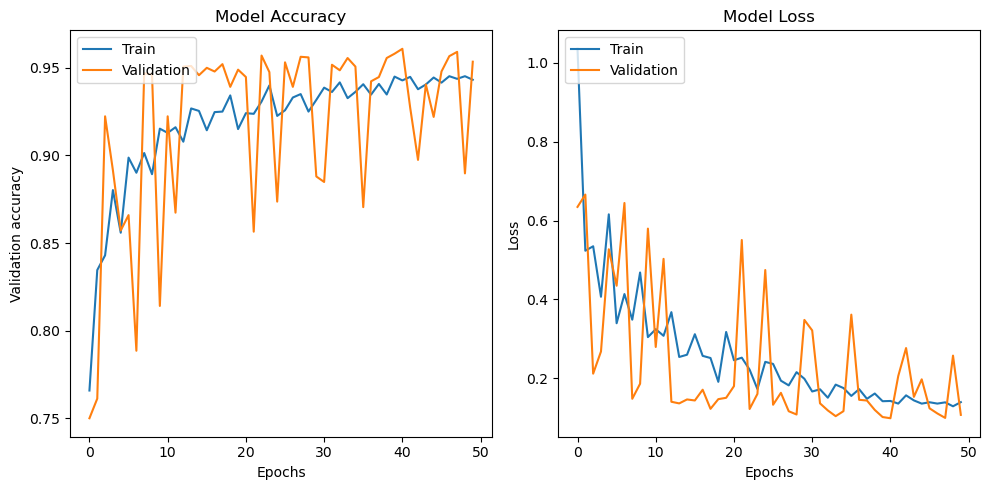

In [38]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.legend(['Train', "Validation"], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', "Validation"], loc='upper left')

plt.tight_layout()
plt.show()

# Although the validation and training results does not diverge greatly from one another, there is some variability in the model. This could be due to the over sampling technique and the heavy class imbalance

# SVM Tune

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'model__C': 1, 'model__kernel': 'rbf'}
Best cross-validation score: 0.961
Test accuracy: 0.957
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2821
           1       0.95      0.97      0.96      2893

    accuracy                           0.96      5714
   macro avg       0.96      0.96      0.96      5714
weighted avg       0.96      0.96      0.96      5714



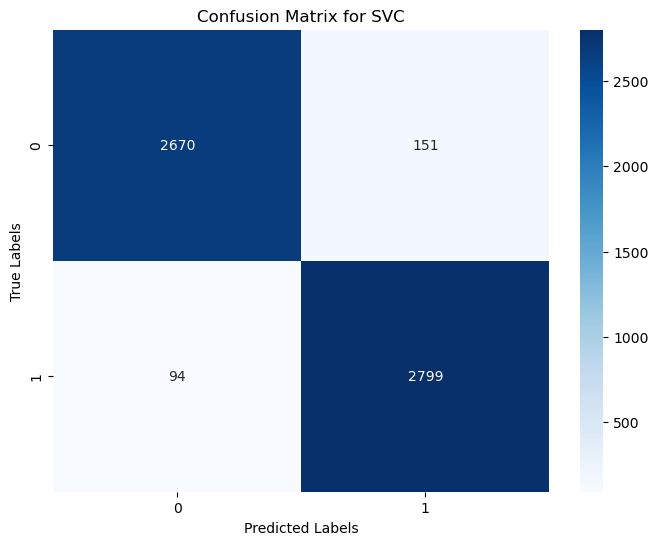

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('power_transformer',
                                        PowerTransformer()),
                                       ('model', SVC())]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1],
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [40]:
svm_tune_grid_search(X_bl, y_bl)

# LR Tune

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'model__C': 4, 'model__solver': 'newton-cg'}
Best cross-validation score: 0.936
Test accuracy: 0.942
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2821
           1       0.94      0.94      0.94      2893

    accuracy                           0.94      5714
   macro avg       0.94      0.94      0.94      5714
weighted avg       0.94      0.94      0.94      5714



/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


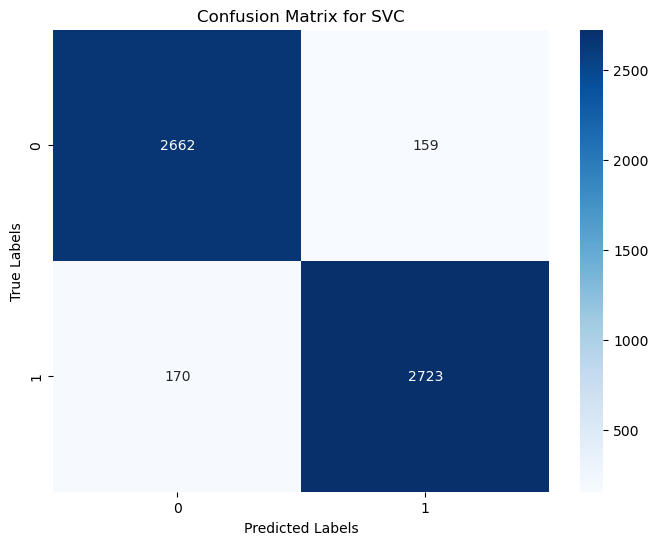

In [41]:
logistic_regression_tune_cv(X_bl, y_bl)

# Tree models

Best score for DTC: 0.975
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__splitter': 'best'}
Validation Test accuracy for DTC: 0.974
Test accuracy for DTC: 0.977
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1404
           1       0.97      0.98      0.98      1453

    accuracy                           0.98      2857
   macro avg       0.98      0.98      0.98      2857
weighted avg       0.98      0.98      0.98      2857



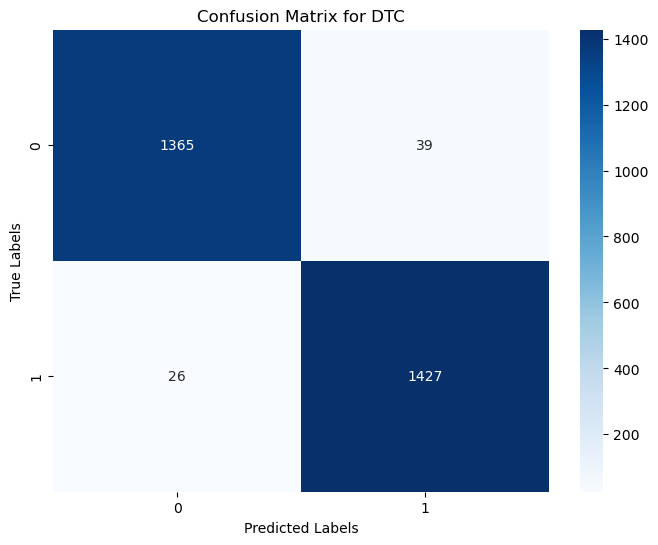

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best score for RFC: 0.980
Best parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Validation Test accuracy for RFC: 0.981
Test accuracy for RFC: 0.985
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1404
           1       0.98      0.99      0.99      1453

    accuracy                           0.98      2857
   macro avg       0.98      0.98      0.98      2857
weighted avg       0.98      0.98      0.98      2857



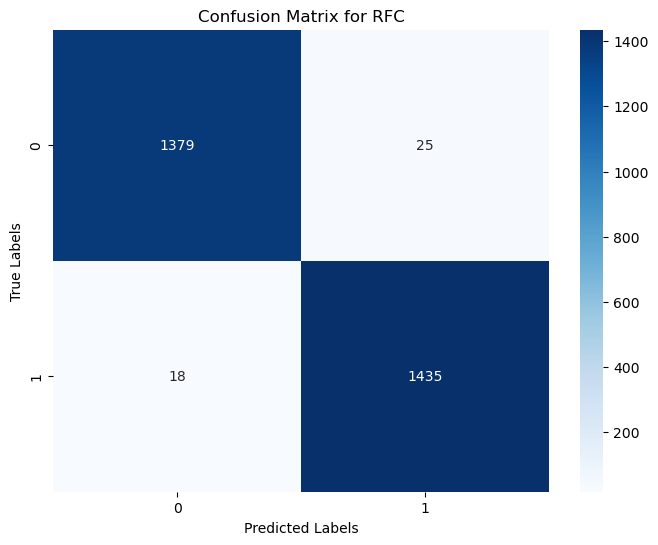

Best score for GBC: 0.981
Best parameters: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 300}
Validation Test accuracy for GBC: 0.984
Test accuracy for GBC: 0.986
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1404
           1       0.99      0.99      0.99      1453

    accuracy                           0.99      2857
   macro avg       0.99      0.99      0.99      2857
weighted avg       0.99      0.99      0.99      2857



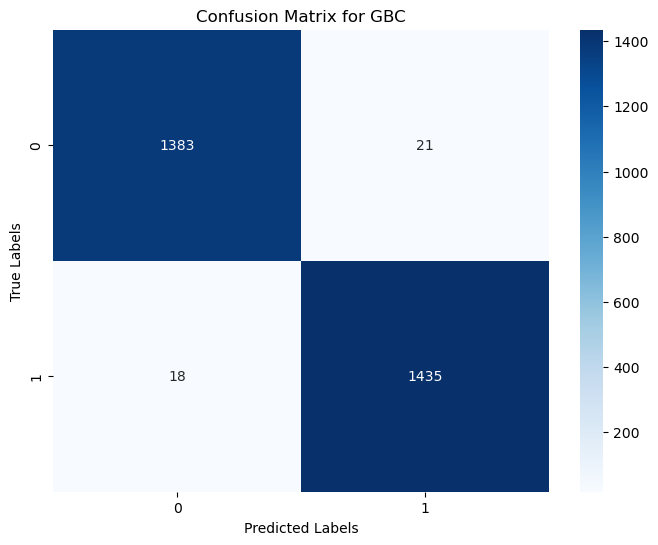

Best score for XGB: 0.980
Best parameters: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 300}
Validation Test accuracy for XGB: 0.981
Test accuracy for XGB: 0.986
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1404
           1       0.98      0.99      0.99      1453

    accuracy                           0.99      2857
   macro avg       0.99      0.99      0.99      2857
weighted avg       0.99      0.99      0.99      2857



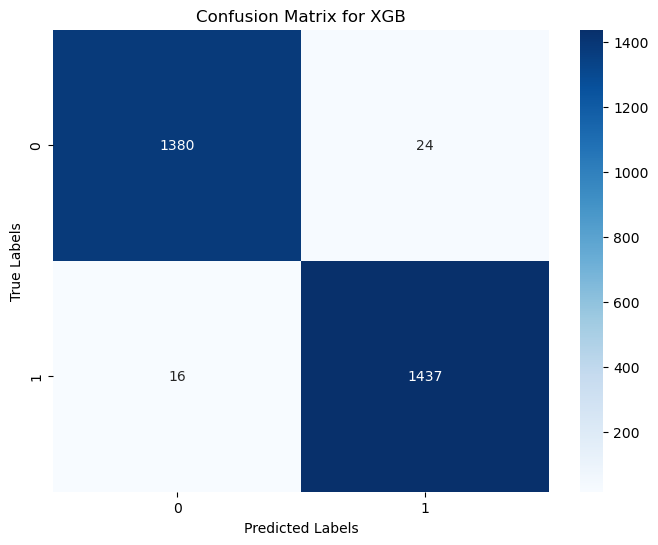

,Model,Best CV Score,Validation Accuracy,Test Accuracy,Best Parameters
2,GBC,0.981245,0.983549,0.986349,"{'model__learning_rate': 0.2, 'model__max_dept..."
3,XGB,0.980194,0.981099,0.985999,"{'model__learning_rate': 0.2, 'model__max_dept..."
1,RFC,0.979519,0.980749,0.984949,"{'model__max_depth': 30, 'model__min_samples_l..."
0,DTC,0.975279,0.974449,0.977249,"{'model__criterion': 'entropy', 'model__max_de..."


In [43]:
names = ["DTC", "RFC", "GBC", "XGB"]
models = get_selected_models(names)

param_grid = {
    'DTC': {
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__splitter': ['best', 'random'] 
    },
    'RFC': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    },
    'GBC': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'XGB': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2]
    }
}

metric = make_scorer(f1_score)
val_grid_search_selected_models(param_grid, names, models, X_bl, y_bl, metric)

# PCA Analysis

In [48]:
pca_analysis(X_bl)

,Number of Components,Cumulative Explained Variance
0,1,0.323176
1,2,0.554605
2,3,0.705569
3,4,0.847766
4,5,0.927539
5,6,0.987964
6,7,1.000000


# 3 - 5 Columns hold 70-90% of the variance

In [ ]:
names = ["RFC", "XGB", "GBC"]

models = [
  RandomForestClassifier(max_depth=30,min_samples_leaf=1,min_samples_split=2,n_estimators=200),
  XGBClassifier(learning_rate=0.2,max_depth=7,n_estimators=300),
  GradientBoostingClassifier(learning_rate=0.2,max_depth=7, n_estimators=300),
]

variance_window = range(3,6+1)
metric = f_classif
test_k_best_columns(names, models, X_bl, y_bl, metric,'F-Stat', variance_window)